In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH

from gptchem.plotsettings import *

%matplotlib inline

## Load results

In [37]:
all_out = glob("out/**/*.pkl")

In [38]:
all_out = [load_pickle(p) for p in all_out]

In [39]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    try:
        res = {
            "train_size": out["train_size"],
            "frac_valid": out["frac_valid"],
            "accuracy": out["accuracy"],
            "f1_macro": out["f1_macro"],
            "f1_micro": out["f1_micro"],
            "kappa": out["kappa"],
            "num_classes": out["num_classes"],
            "representation": out["representation"],
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost_baseline"]["accuracy"],
        "f1_macro": out["xgboost_baseline"]["f1_macro"],
        "f1_micro": out["xgboost_baseline"]["f1_micro"],
        "kappa": out["xgboost_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_baseline"]["accuracy"],
        "f1_macro": out["tabpfn_baseline"]["f1_macro"],
        "f1_micro": out["tabpfn_baseline"]["f1_micro"],
        "kappa": out["tabpfn_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [40]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [41]:
grouped_res = res.groupby(["num_classes", "representation", "train_size"]).agg(["mean", "std", sem])

In [42]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [43]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "train_size"]).agg(["mean", "std", sem])

In [44]:
grouped_res.loc[2, :]

frac_valid            accuracy                      \
                                mean  std  sem      mean       std       sem   
representation train_size                                                      
SMILES         10                1.0  0.0  0.0  0.663077  0.056772  0.015746   
               20                1.0  0.0  0.0  0.738182  0.065699  0.019809   
               50                1.0  0.0  0.0  0.809167  0.044202  0.012760   
               100               1.0  0.0  0.0  0.860909  0.027370  0.008252   
               200               1.0  0.0  0.0  0.872500  0.033063  0.009545   
inchi          10                1.0  0.0  0.0  0.580000  0.084656  0.023479   
               20                1.0  0.0  0.0  0.790000  0.033466  0.010090   
               50                1.0  0.0  0.0  0.817273  0.023277  0.007018   
               100               1.0  0.0  0.0  0.835455  0.042039  0.012675   
               200               1.0  0.0  0.0  0.856364  0.035291  0.010641   
name           10                1.0  0.0  0.0  0.749663  0.103054  0.018218   
               20                1.0  0.0  0.0  0.837010  0.045417  0.013111   
               50                1.0  0.0  0.0  0.858726  0.044909  0.010303   
selfies        10                1.0  0.0  0.0  0.590769  0.074214  0.020583   
               20                1.0  0.0  0.0  0.700000  0.077589  0.023394   
               50                1.0  0.0  0.0  0.766000  0.040879  0.012927   
               100               1.0  0.0  0.0  0.831818  0.037099  0.011186   
               200               1.0  0.0  0.0  0.847000  0.053344  0.016869   

                           f1_macro                      f1_micro            \
                               mean       std       sem      mean       std   
representation train_size                                                     
SMILES         10          0.641876  0.077671  0.021542  0.663077  0.056772   
               20          0.730227  0.073320  0.022107  0.738182  0.065699   
               50          0.808074  0.045029  0.012999  0.809167  0.044202   
               100         0.860459  0.027379  0.008255  0.860909  0.027370   
               200         0.872218  0.033372  0.009634  0.872500  0.033063   
inchi          10          0.528971  0.132754  0.036819  0.580000  0.084656   
               20          0.786820  0.034876  0.010516  0.790000  0.033466   
               50          0.816229  0.023690  0.007143  0.817273  0.023277   
               100         0.834967  0.042151  0.012709  0.835455  0.042039   
               200         0.856221  0.035327  0.010652  0.856364  0.035291   
name           10          0.735287  0.134059  0.023699  0.749663  0.103054   
               20          0.835383  0.046279  0.013360  0.837010  0.045417   
               50          0.857592  0.045555  0.010451  0.858726  0.044909   
selfies        10          0.555032  0.106606  0.029567  0.590769  0.074214   
               20          0.689477  0.091349  0.027543  0.700000  0.077589   
               50          0.764209  0.042167  0.013334  0.766000  0.040879   
               100         0.831324  0.037086  0.011182  0.831818  0.037099   
               200         0.846642  0.053471  0.016909  0.847000  0.053344   

                                        kappa                      
                                sem      mean       std       sem  
representation train_size                                          
SMILES         10          0.015746  0.326154  0.113544  0.031492  
               20          0.019809  0.476364  0.131398  0.039618  
               50          0.012760  0.618333  0.088403  0.025520  
               100         0.008252  0.721818  0.054739  0.016504  
               200         0.009545  0.745000  0.066127  0.019089  
inchi          10          0.023479  0.160000  0.169312  0.046959  
               20          0.010090  0.580000  0.066933  0.020181  
     

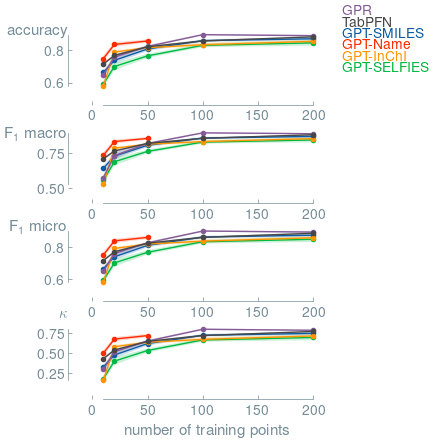

In [56]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[2, "SMILES", :].index,
        grouped_res.loc[2, "SMILES", :][metric]["mean"],
        marker="o",
        label="GPT-SMILES",
    )
    ax[i].fill_between(
        grouped_res.loc[2, "SMILES", :].index,
        grouped_res.loc[2, "SMILES", :][metric]["mean"]
        - grouped_res.loc[2, "SMILES", :][metric]["sem"],
        grouped_res.loc[2, "SMILES", :][metric]["mean"]
        + grouped_res.loc[2, "SMILES", :][metric]["sem"],
        alpha=0.2,
    )

    range_frame(
        ax[i],
        grouped_res.loc[2, "SMILES", :].index,
        np.vstack(
            [
                grouped_res.loc[2, "SMILES", :][metric]["mean"].values.reshape(-1,1),
                grouped_res.loc[2, "selfies", :][metric]["mean"].values.reshape(-1,1),
                grouped_res.loc[2, "inchi", :][metric]["mean"].values.reshape(-1,1),
                grouped_res.loc[2, "name", :][metric]["mean"].values.reshape(-1,1),
                grouped_xgboost_res.loc[2, :][metric]["mean"].values.reshape(-1,1),
                grouped_tabpfn_res.loc[2, :][metric]["mean"].values.reshape(-1,1),
            ]
        ).flatten(),
    )

    ax[i].plot(
        grouped_res.loc[2, "selfies", :].index,
        grouped_res.loc[2, "selfies", :][metric]["mean"],
        marker="o",
        label="GPT-SELFIES",
    )
    ax[i].fill_between(
        grouped_res.loc[2, "selfies", :].index,
        grouped_res.loc[2, "selfies", :][metric]["mean"]
        - grouped_res.loc[2, "selfies", :][metric]["sem"],
        grouped_res.loc[2, "selfies", :][metric]["mean"]
        + grouped_res.loc[2, "selfies", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[2, "inchi", :].index,
        grouped_res.loc[2, "inchi", :][metric]["mean"],
        marker="o",
        label="GPT-InChI",
    )
    ax[i].fill_between(
        grouped_res.loc[2, "inchi", :].index,
        grouped_res.loc[2, "inchi", :][metric]["mean"]
        - grouped_res.loc[2, "inchi", :][metric]["sem"],
        grouped_res.loc[2, "inchi", :][metric]["mean"]
        + grouped_res.loc[2, "inchi", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[2, "name", :].index,
        grouped_res.loc[2, "name", :][metric]["mean"],
        marker="o",
        label="GPT-Name",
    )
    ax[i].fill_between(
        grouped_res.loc[2, "name", :].index,
        grouped_res.loc[2, "name", :][metric]["mean"]
        - grouped_res.loc[2, "name", :][metric]["sem"],
        grouped_res.loc[2, "name", :][metric]["mean"]
        + grouped_res.loc[2, "name", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :][metric]["mean"],
        marker="o",
        label="GPR",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :][metric]["mean"]
        - grouped_xgboost_res.loc[2, :][metric]["sem"],
        grouped_xgboost_res.loc[2, :][metric]["mean"]
        + grouped_xgboost_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :][metric]["mean"] - grouped_tabpfn_res.loc[2, :][metric]["sem"],
        grouped_tabpfn_res.loc[2, :][metric]["mean"] + grouped_tabpfn_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

matplotx.line_labels(ax[0])
ylabel_top("accuracy", ax=ax[0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], y_pad=0.1, x_pad=0.04)
ylabel_top(r"$\kappa$", ax=ax[3], y_pad=0.1, x_pad=0.04)
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
ax[-1].set_xlabel("number of training points", labelpad=4)

fig.savefig("photoswitch-classification_results_binary.pdf", bbox_inches="tight")

In [57]:
intersections = []

for i, val in enumerate(grouped_res.loc[2, "name", :].index):
    factor= find_learning_curve_intersection(
    grouped_res.loc[2, "name", :]["f1_macro"]["mean"].values[i],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / val

    intersections.append(factor)

In [58]:
intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[2, "name", :].index):
    factor= find_learning_curve_intersection(
    grouped_res.loc[2, "name", :]["f1_macro"]["mean"].values[i],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / val

    intersections_tabpfn.append(factor)

In [59]:
from gptchem.evaluator import get_kappa_intersections, add_kappa_vlines

In [60]:
get_kappa_intersections(
      grouped_res.loc[2, "SMILES", :].index.values,
    grouped_res.loc[2, "SMILES", :]["kappa"]["mean"].values,
)

{0: -0.3325822597631418,
 0.2: 5.862727053231399,
 0.4: 15.116261465167705,
 0.6: 33.883297895010294,
 0.8: 654.4947285329912}

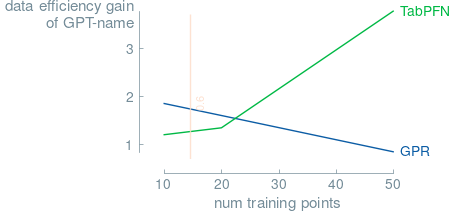

In [75]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(1, 1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
ax.plot(grouped_res.loc[2, "name", :].index, intersections, label='GPR')
ax.plot(grouped_res.loc[2, "name", :].index, intersections_tabpfn, label='TabPFN')
matplotx.line_labels()

ylabel_top('data efficiency gain\n of GPT-name', x_pad=0.05, y_pad=-.01)
plt.xlabel('num training points', labelpad=4)

add_kappa_vlines(
      grouped_res.loc[2, "name", :].index.values,
    grouped_res.loc[2, "name", :]["kappa"]["mean"].values,
    ymax=3.7
)

range_frame(
  ax,
       grouped_res.loc[2, "name", :].index.values,
       np.stack(
        [
         intersections ,
        intersections_tabpfn 
        ]
       ).flatten(),
       0.05
)
plt.savefig('photoswitch-binary-data-efficiency.pdf', bbox_inches='tight')

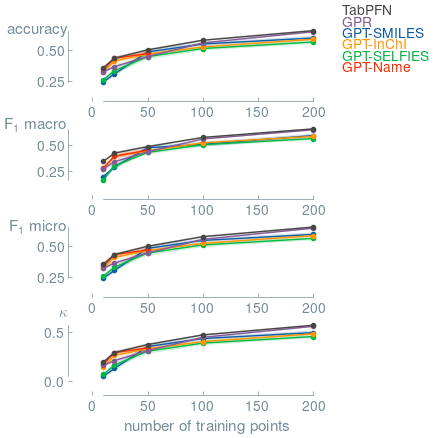

In [77]:

fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[5, "SMILES", :].index,
        grouped_res.loc[5, "SMILES", :][metric]["mean"],
        marker="o",
        label="GPT-SMILES",
    )
    ax[i].fill_between(
        grouped_res.loc[5, "SMILES", :].index,
        grouped_res.loc[5, "SMILES", :][metric]["mean"]
        - grouped_res.loc[5, "SMILES", :][metric]["sem"],
        grouped_res.loc[5, "SMILES", :][metric]["mean"]
        + grouped_res.loc[5, "SMILES", :][metric]["sem"],
        alpha=0.2,
    )

    range_frame(
        ax[i],
        grouped_res.loc[5, "SMILES", :].index,
        np.vstack(
            [
                grouped_res.loc[5, "SMILES", :][metric]["mean"].values.reshape(-1,1),
                grouped_res.loc[5, "selfies", :][metric]["mean"].values.reshape(-1,1),
                grouped_res.loc[5, "inchi", :][metric]["mean"].values.reshape(-1,1),
                grouped_res.loc[5, "name", :][metric]["mean"].values.reshape(-1,1),
                grouped_xgboost_res.loc[5, :][metric]["mean"].values.reshape(-1,1),
                grouped_tabpfn_res.loc[5, :][metric]["mean"].values.reshape(-1,1),
            ]
        ).flatten(),
    )

    ax[i].plot(
        grouped_res.loc[5, "selfies", :].index,
        grouped_res.loc[5, "selfies", :][metric]["mean"],
        marker="o",
        label="GPT-SELFIES",
    )
    ax[i].fill_between(
        grouped_res.loc[5, "selfies", :].index,
        grouped_res.loc[5, "selfies", :][metric]["mean"]
        - grouped_res.loc[5, "selfies", :][metric]["sem"],
        grouped_res.loc[5, "selfies", :][metric]["mean"]
        + grouped_res.loc[5, "selfies", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[5, "inchi", :].index,
        grouped_res.loc[5, "inchi", :][metric]["mean"],
        marker="o",
        label="GPT-InChI",
    )
    ax[i].fill_between(
        grouped_res.loc[5, "inchi", :].index,
        grouped_res.loc[5, "inchi", :][metric]["mean"]
        - grouped_res.loc[5, "inchi", :][metric]["sem"],
        grouped_res.loc[5, "inchi", :][metric]["mean"]
        + grouped_res.loc[5, "inchi", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_res.loc[5, "name", :].index,
        grouped_res.loc[5, "name", :][metric]["mean"],
        marker="o",
        label="GPT-Name",
    )
    ax[i].fill_between(
        grouped_res.loc[5, "name", :].index,
        grouped_res.loc[5, "name", :][metric]["mean"]
        - grouped_res.loc[5, "name", :][metric]["sem"],
        grouped_res.loc[5, "name", :][metric]["mean"]
        + grouped_res.loc[5, "name", :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[5, :].index,
        grouped_xgboost_res.loc[5, :][metric]["mean"],
        marker="o",
        label="GPR",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5, :].index,
        grouped_xgboost_res.loc[5, :][metric]["mean"]
        - grouped_xgboost_res.loc[5, :][metric]["sem"],
        grouped_xgboost_res.loc[5, :][metric]["mean"]
        + grouped_xgboost_res.loc[5, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5, :].index,
        grouped_tabpfn_res.loc[5, :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5, :].index,
        grouped_tabpfn_res.loc[5, :][metric]["mean"]
        - grouped_tabpfn_res.loc[5, :][metric]["sem"],
        grouped_tabpfn_res.loc[5, :][metric]["mean"]
        + grouped_tabpfn_res.loc[5, :][metric]["sem"],
        alpha=0.2,
    )

matplotx.line_labels(ax[0])
ylabel_top("accuracy", ax=ax[0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], y_pad=0.1, x_pad=0.04)
ylabel_top(r"$\kappa$", ax=ax[3], y_pad=0.1, x_pad=0.04)
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
ax[-1].set_xlabel("number of training points", labelpad=4)

fig.savefig("photoswitch-classification_results_5_class.pdf", bbox_inches="tight")

In [78]:
intersections = []

for i, val in enumerate(grouped_res.loc[5, "name", :].index):
    factor= find_learning_curve_intersection(
    grouped_res.loc[5, "name", :]["f1_macro"]["mean"].values[i],
    fit_learning_curve(
        grouped_xgboost_res.loc[5, :].index,
        grouped_xgboost_res.loc[5, :]["f1_macro"]["mean"],
    )[0],
) / val

    intersections.append(factor)


intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[5, "name", :].index):
    factor= find_learning_curve_intersection(
    grouped_res.loc[5, "name", :]["f1_macro"]["mean"].values[i],
    fit_learning_curve(
        grouped_tabpfn_res.loc[5, :].index,
        grouped_tabpfn_res.loc[5, :]["f1_macro"]["mean"],
    )[0],
) / val

    intersections_tabpfn.append(factor)

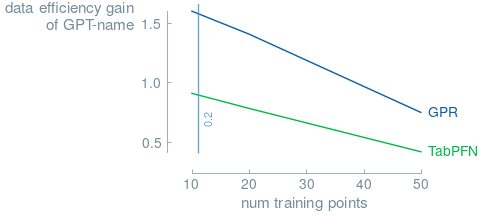

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))

ax.plot(grouped_res.loc[2, "name", :].index, intersections, label='GPR')
ax.plot(grouped_res.loc[2, "name", :].index, intersections_tabpfn, label='TabPFN')
matplotx.line_labels()

ylabel_top('data efficiency gain\n  of GPT-name', y_pad=-0.2, x_pad=0.16)
plt.xlabel('num training points', labelpad=4)

add_kappa_vlines(
      grouped_res.loc[5, "name", :].index.values,
    grouped_res.loc[5, "name", :]["kappa"]["mean"].values,
    ymin=.4, ymax=1.7
)

range_frame(
  ax,
       grouped_res.loc[5, "name", :].index.values,
       np.stack(
        [
         intersections ,
        intersections_tabpfn 
        ]
       ).flatten(),
       0.05
)

plt.savefig('photoswitch-5-data-efficiency.pdf', bbox_inches='tight')